In [9]:
import src.db_read as dbrd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import contextily as ctx
from shapely.geometry import box
import geopandas as gpd

### Retrieve all grids which are not fillers (plz, bcid, kcid, location) + census

In [13]:
### Create database object to read grid data from pylovo database
DB = dbrd.DataBase()
DB.show_contents()

Available tables:
['spatial_ref_sys', 'geography_columns', 'geometry_columns', 'res', 'oth', 'betriebsmittel', 'building_clusters', 'lines_result', 'buildings_result', 'sample_set', 'clustering_parameters', 'classification_version', 'buildings_tem', 'consumer_categories', 'postcode_result', 'transformer_classified', 'ags_log', 'ways', 'loadarea', 'postcode', 'transformer_positions', 'transformers', 'ways_result', 'ways_tem', 'grids', 'version', 'grid_parameters', 'ways_tem_vertices_pgr', 'public_2po_4pgr', 'municipal_register']


In [14]:
### Read out all generated grid specifiers and (for now) select first one
df_generated_grids = DB.read_nonfiller_grid_identifiers()

Retrieved 4971 generated grids!


In [15]:
# Read out location string
def retrieve_coord_string(loc):
    match = re.match(r"POINT\(([-+]?[0-9]*\.?[0-9]+)\s*([-+]?[0-9]*\.?[0-9]+)\)", loc)
    if match:
        x = float(match.group(1))
        y = float(match.group(2))
    return (x,y)

In [16]:
df_generated_grids[["x","y"]] = df_generated_grids["loc"].apply(retrieve_coord_string).apply(pd.Series)
df_generated_grids.drop(inplace=True, columns=["loc"])

In [17]:
df_generated_grids

,plz,kcid,bcid,x,y
0,90461,1,22,4.400701e+06,2.925878e+06
1,80933,1,-2,4.437005e+06,2.790850e+06
2,81829,1,21,4.446704e+06,2.780981e+06
3,81829,1,22,4.446772e+06,2.781089e+06
4,81927,1,22,4.442523e+06,2.783343e+06
...,...,...,...,...,...
4966,89349,1,29,4.354377e+06,2.802532e+06
4967,89349,1,32,4.354676e+06,2.803477e+06
4968,89349,1,33,4.354155e+06,2.802827e+06
4969,89349,1,34,4.354294e+06,2.802824e+06


In [18]:
df_census = pd.read_csv(
    "input_data/Zensus2022_Bevoelkerungszahl_1km-Gitter.csv",
    sep=";",
    header=0)
df_census

,GITTER_ID_1km,x_mp_1km,y_mp_1km,Einwohner
0,CRS3035RES1000mN2689000E4337000,4337500,2689500,4
1,CRS3035RES1000mN2689000E4341000,4341500,2689500,11
2,CRS3035RES1000mN2690000E4341000,4341500,2690500,4
3,CRS3035RES1000mN2691000E4340000,4340500,2691500,3
4,CRS3035RES1000mN2691000E4341000,4341500,2691500,22
...,...,...,...,...
210551,CRS3035RES1000mN3546000E4219000,4219500,3546500,69
210552,CRS3035RES1000mN3546000E4220000,4220500,3546500,587
210553,CRS3035RES1000mN3547000E4219000,4219500,3547500,144
210554,CRS3035RES1000mN3547000E4220000,4220500,3547500,530


### Remove grids which are not close to inhabited cell

In [19]:
def retrieve_closest_inhabitants_per_km2(x,y, df_census):
    # Calculate squared Euclidean distance
    distances = (df_census["x_mp_1km"] - x)**2 + (df_census["y_mp_1km"] - y)**2
    idx_min = distances.idxmin()
    dist_min = np.sqrt(distances.min())

    closest_row = df_census.loc[idx_min]
    return closest_row["Einwohner"], closest_row["x_mp_1km"], closest_row["y_mp_1km"], dist_min

In [20]:
df_generated_grids[["Einwohner","x_census","y_census","dist"]] = df_generated_grids.apply(lambda row: retrieve_closest_inhabitants_per_km2(row["x"],row["y"],df_census), axis=1).apply(pd.Series)

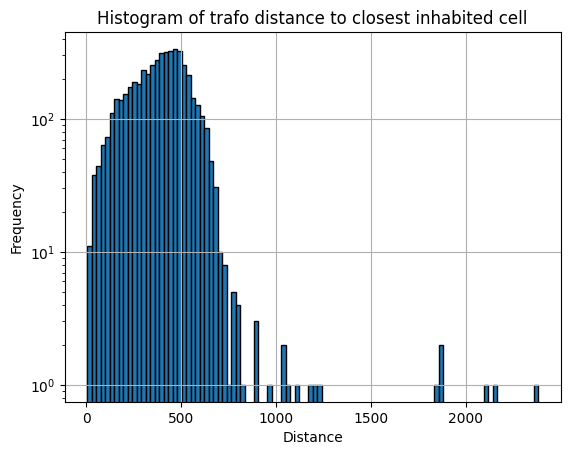

In [21]:
plt.hist(df_generated_grids['dist'], bins=100, edgecolor='black')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.yscale("log")
plt.title('Histogram of trafo distance to closest inhabited cell')
plt.grid(True)
plt.show()

In [22]:
df_generated_grids = df_generated_grids[df_generated_grids["dist"]<=np.sqrt(2*500**2)]

In [23]:
df_generated_grids

,plz,kcid,bcid,x,y,Einwohner,x_census,y_census,dist
0,90461,1,22,4.400701e+06,2.925878e+06,13424.0,4400500.0,2925500.0,427.867349
1,80933,1,-2,4.437005e+06,2.790850e+06,2579.0,4437500.0,2790500.0,606.785569
2,81829,1,21,4.446704e+06,2.780981e+06,1255.0,4446500.0,2780500.0,522.535644
3,81829,1,22,4.446772e+06,2.781089e+06,4195.0,4446500.0,2781500.0,492.482161
4,81927,1,22,4.442523e+06,2.783343e+06,5266.0,4442500.0,2783500.0,158.663069
...,...,...,...,...,...,...,...,...,...
4966,89349,1,29,4.354377e+06,2.802532e+06,1135.0,4354500.0,2802500.0,126.861421
4967,89349,1,32,4.354676e+06,2.803477e+06,970.0,4354500.0,2803500.0,177.453067
4968,89349,1,33,4.354155e+06,2.802827e+06,1135.0,4354500.0,2802500.0,475.068156
4969,89349,1,34,4.354294e+06,2.802824e+06,1135.0,4354500.0,2802500.0,383.651272


In [27]:
df_generated_grids.drop(columns=["dist"]).to_hdf("input_data/valid_grids", key="grids")

### Create Map

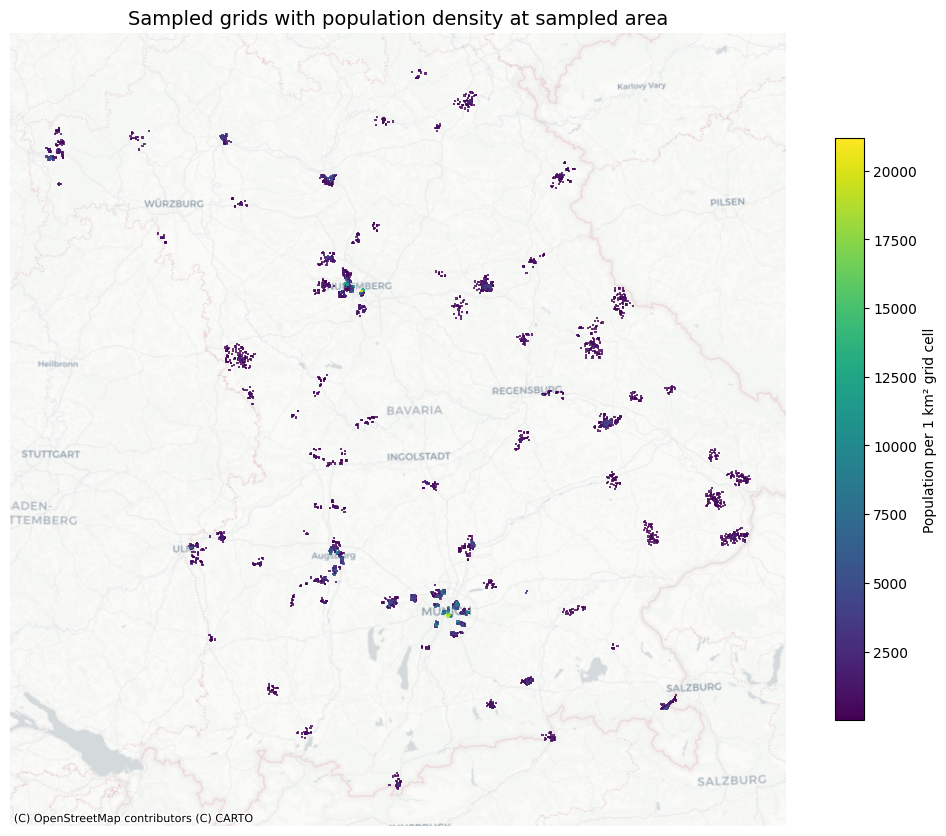

In [28]:
# Step 1: Load the CSV with centroids in EPSG:3035
df = df_generated_grids

# Step 2: Column definitions
x_col    = "x"    # centroid X [m]
y_col    = "y"    # centroid Y [m]
pop_col  = "Einwohner"    # population

half_size = 500          # half side‐length in metres

# Step 3: Build square polygons in EPSG:3035
polygons = df.apply(
    lambda row: box(
        row[x_col] - half_size,
        row[y_col] - half_size,
        row[x_col] + half_size,
        row[y_col] + half_size
    ),
    axis=1
)

gdf = gpd.GeoDataFrame(
    df[[pop_col]],
    geometry=polygons,
    crs="EPSG:3035"
)

# Step 4: Plot in EPSG:3035 so boxes remain true squares
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the grid cells
gdf.plot(
    ax=ax,
    column=pop_col,
    cmap="viridis",
    linewidth=0,
    edgecolor="none",
    alpha=0.8,
    legend=True,
    legend_kwds={
        "label": "Population per 1 km² grid cell",
        "shrink": 0.6
    }
)

# Optional: add a basemap reprojected on the fly
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,
    crs=gdf.crs.to_string()
)

# Formatting
ax.set_title(
    "Sampled grids with population density at sampled area",
    fontsize=14
)
ax.set_aspect("equal")      # ensure equal axis scales
ax.set_axis_off()

plt.tight_layout()
plt.show()

### Plot Distributions of grids and census cells

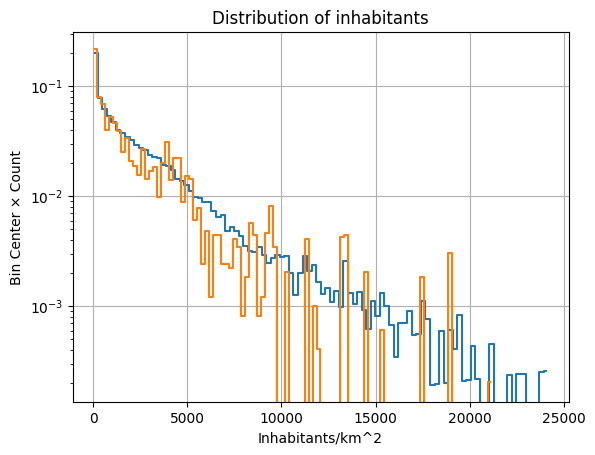

In [29]:
counts_grids, bin_edges_grids = np.histogram(df_generated_grids["Einwohner"], bins=100)
bin_centers_grids = 0.5 * (bin_edges_grids[1:] + bin_edges_grids[:-1])


# Compute histogram data without plotting it
counts_census, bin_edges_census = np.histogram(df_census["Einwohner"], bins=100)

# Compute bin centers
bin_centers_census = 0.5 * (bin_edges_census[1:] + bin_edges_census[:-1])

# Compute bin_center * count
bin_value_times_count_census = bin_centers_census * counts_census

# Plot the result
plt.plot(bin_centers_census, bin_value_times_count_census/np.sum(bin_value_times_count_census), drawstyle='steps-mid')
plt.plot(bin_centers_grids, counts_grids/len(df_generated_grids), drawstyle='steps-mid')
plt.xlabel('Inhabitants/km^2')
plt.ylabel('Bin Center × Count')
plt.yscale("log")
plt.title('Distribution of inhabitants')
plt.grid(True)
plt.show()

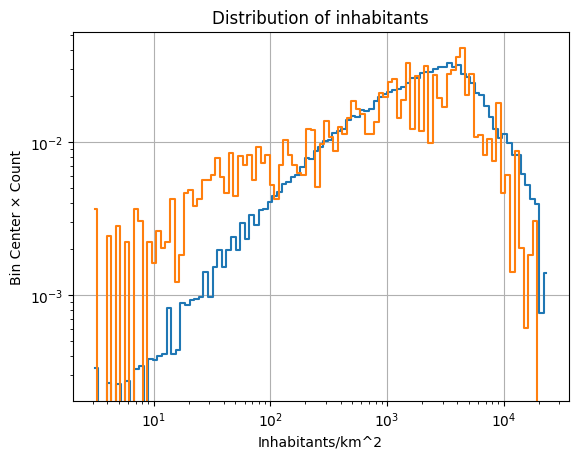

In [30]:
# Define minimum and maximum values for the histogram
min_val_grids = df_generated_grids["Einwohner"][df_generated_grids["Einwohner"] > 0].min()
max_val_grids = df_generated_grids["Einwohner"].max()

# Define number of logarithmic bins
num_bins_grids = 100

# Create logarithmically spaced bins
bin_edges_grids = np.logspace(np.log10(min_val_grids), np.log10(max_val_grids), num=num_bins_grids)

counts_grids, bin_edges_grids = np.histogram(df_generated_grids["Einwohner"], bins=bin_edges_grids)
bin_centers_grids = 0.5 * (bin_edges_grids[1:] + bin_edges_grids[:-1])

#-------------------
# Define minimum and maximum values for the histogram
min_val = df_census["Einwohner"][df_census["Einwohner"] > 0].min()
max_val = df_census["Einwohner"].max()

# Define number of logarithmic bins
num_bins = 100

# Create logarithmically spaced bins
bin_edges_census = np.logspace(np.log10(min_val), np.log10(max_val), num=num_bins)

# Compute histogram with logarithmic bins
counts_census, _ = np.histogram(df_census["Einwohner"], bins=bin_edges_census)

# Compute bin centers
bin_centers_census = 0.5 * (bin_edges_census[1:] + bin_edges_census[:-1])

# Compute bin_center * count
bin_value_times_count_census = bin_centers_census * counts_census

# Plot
plt.plot(bin_centers_census, bin_value_times_count_census / np.sum(bin_value_times_count_census), drawstyle='steps-mid')

# Plot the other dataset (you must ensure bin_centers_grids and counts_grids are defined analogously)
plt.plot(bin_centers_grids, counts_grids / len(df_generated_grids), drawstyle='steps-mid')

plt.xlabel('Inhabitants/km^2')
plt.ylabel('Bin Center × Count')
plt.xscale("log")
plt.yscale("log")
plt.title('Distribution of inhabitants')
plt.grid(True)
plt.show()
